# These are the Cartography visuals.

# To Do:
- delete obsolete imports
- finish snakemake files for zika and seasonal flu, talk about organization with John
- add snakemake commands instead of explicit paths once main snakefile is updated
- delete supplements after exhaustive grid search
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [9]:
import pandas as pd
import altair as alt
import numpy as np
from scipy.spatial.distance import squareform, pdist
from Bio import SeqIO
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from augur.utils import json_to_tree
import json
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap
from scipy.stats import linregress
from pathlib import Path
import statsmodels
import statistics
import matplotlib.pyplot as plt
from Helpers import get_euclidean_data_frame, get_hamming_distances, linking_tree_with_plots_brush
from Helpers import linking_tree_with_plots_clickable
from Helpers import scatterplot_xyvalues, scatterplot_tooltips, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions
import selenium
from selenium.webdriver import Chrome 
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from Helpers import get_y_positions
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [ ]:
if snakemake.input.tree is not None:
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)

## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [ ]:
path = snakemake.input.alignment
dropped_strains = [line.rstrip('\n') for line in open(snakemake.input.dropped_strains,"r")]
tree_path = snakemake.input.tree
if snakemake.input.clade_names is not None:
    clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
f = open(snakemake.input.disease_name, "r")
virus_name = f.read()

### Old Flu Files

In [10]:
path = "../seasonal-flu-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = []
tree_path = "../seasonal-flu-nextstrain/auspice-20182020/flu_seasonal_h3n2_ha_2y.json"
virus_name = "Flu"
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

# Zika Specific Variables 

In [ ]:
path = "../zika-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = ["Yunnan/01/2019"]
distance_matrix_file = "DistanceMatrixZika.csv"
tree_path = '../zika-nextstrain/auspice-20182020/zika-cartography_tree.json'
virus_name = "Zika"
clades_to_plot = None

# Reading in all the data from the scripts

In [11]:
similarity_matrix = pd.read_csv("../seasonal-flu-nextstrain/results/distance_matrix_tsne.csv", index_col=0)

In [12]:
similarity_matrix.index = principalDf = pd.read_csv("../seasonal-flu-nextstrain/results/embed_pca.csv", index_col=0).index

In [13]:
similarity_matrix.columns = similarity_matrix.index

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html

In [14]:
with open(tree_path) as fh:
    json_tree_handle = json.load(fh)

In [15]:
tree = json_to_tree(json_tree_handle)

In [16]:
tree

Clade(branch_length=0, name='NODE_0000000')

In [17]:
heights = get_y_positions(tree)
for node in tree.find_clades():
    node.yvalue = heights[node]

In [18]:
node_data = [
    {
        "strain": node.name,
        "date": node.node_attrs["num_date"]["value"],
        "y": node.yvalue,
        "region": node.node_attrs["region"]["value"],
        "country": node.node_attrs["country"]["value"],
        "parent_date": node.parent is not None and node.parent.node_attrs["num_date"]["value"] or node.node_attrs["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.node_attrs['clade_membership']["value"]
    }
    for node in tree.find_clades(terminal=True)
]

In [19]:
node_data[10]

{'strain': 'A/Germany/7354/2018',
 'date': 2018.1986301369864,
 'y': 11,
 'region': 'N',
 'country': 'Germany',
 'parent_date': 2018.0403714864015,
 'parent_y': 11.9375,
 'clade_membership': '3c3.A'}

In [20]:
node_df = pd.DataFrame(node_data)

In [21]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/Minnesota/40/2018,2018.543836,1,N,USA,2017.963472,1.500000,3c3.A
1,A/Oklahoma/11/2018,2018.113699,2,N,USA,2017.963472,1.500000,3c3.A
2,A/Ohio/23/2018,2018.524658,3,N,USA,2018.046293,3.500000,3c3.A
3,A/Florida/83/2018,2018.675342,4,N,USA,2018.046293,3.500000,3c3.A
4,A/England/7208/2018,2018.256164,5,N,United Kingdom,2017.854815,7.106453,3c3.A


In [22]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [23]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [24]:
node_df.shape

(707, 8)

In [25]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/Minnesota/40/2018,2018.543836,706,N,USA,2017.963472,705.000000,3c3.A
1,A/Oklahoma/11/2018,2018.113699,705,N,USA,2017.963472,705.000000,3c3.A
2,A/Ohio/23/2018,2018.524658,704,N,USA,2018.046293,703.000000,3c3.A
3,A/Florida/83/2018,2018.675342,703,N,USA,2018.046293,703.000000,3c3.A
4,A/England/7208/2018,2018.256164,702,N,United Kingdom,2017.854815,699.393547,3c3.A


In [26]:
node_df["region"].unique()

array(['N', 'S', 'T'], dtype=object)

In [27]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

In [28]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

,A/Alabama/30/2017,A/Florida/84/2017,A/NorthDakota/23/2017,A/Florida/18/2018,A/Indiana/31/2017,A/SouthAustralia/13/2018,A/Sydney/25/2018,A/Newcastle/21/2018,A/Sydney/55/2018,A/Sydney/93/2018,...,A/Georgia/06/2019,A/Idaho/11/2019,A/Michigan/381/2019,A/Hawaii/48/2019,A/Hawaii/41/2019,A/Ohio/08/2019,A/Florida/78/2019,A/California/16/2020,A/Minnesota/40/2018,A/Oklahoma/11/2018
A/Alabama/30/2017,0,2,2,7,7,8,9,8,7,9,...,62,61,62,66,63,62,63,67,54,57
A/Florida/84/2017,2,0,2,7,8,8,9,8,7,9,...,62,61,62,66,63,62,63,67,54,57
A/NorthDakota/23/2017,2,2,0,7,8,8,9,8,7,9,...,62,61,62,66,63,62,63,67,54,57
A/Florida/18/2018,7,7,7,0,7,7,8,7,6,8,...,62,61,62,66,61,62,61,67,54,57
A/Indiana/31/2017,7,8,8,7,0,8,9,8,7,9,...,63,62,63,67,64,63,64,68,55,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A/Ohio/08/2019,62,62,62,62,63,61,64,63,62,64,...,6,6,6,10,9,0,11,13,29,32
A/Florida/78/2019,63,63,63,61,64,62,65,64,63,65,...,9,9,9,13,8,11,0,18,30,33
A/California/16/2020,67,67,67,67,68,66,69,68,67,69,...,13,13,13,17,16,13,18,0,32,35
A/Minnesota/40/2018,54,54,54,54,55,51,54,55,54,56,...,27,27,27,31,28,29,30,32,0,5


In [29]:
node_df

,strain,date,y,region,country,parent_date,parent_y,clade_membership,clade_membership_color
0,A/Minnesota/40/2018,2018.543836,706,N,USA,2017.963472,705.000000,3c3.A,3c3.A
1,A/Oklahoma/11/2018,2018.113699,705,N,USA,2017.963472,705.000000,3c3.A,3c3.A
2,A/Ohio/23/2018,2018.524658,704,N,USA,2018.046293,703.000000,3c3.A,3c3.A
3,A/Florida/83/2018,2018.675342,703,N,USA,2018.046293,703.000000,3c3.A,3c3.A
4,A/England/7208/2018,2018.256164,702,N,United Kingdom,2017.854815,699.393547,3c3.A,3c3.A
...,...,...,...,...,...,...,...,...,...
702,A/Washington/9847/2019,2019.604110,4,N,USA,2019.445500,2.562500,A1b/197R,A1b/197R
703,A/Idaho/43/2019,2019.916438,3,N,USA,2019.515818,1.625000,A1b/197R,A1b/197R
704,A/Montana/55/2019,2019.867123,2,N,USA,2019.563924,0.750000,A1b/197R,A1b/197R
705,A/Connecticut/43/2019,2019.982192,1,N,USA,2019.620548,0.000000,A1b/197R,A1b/197R


# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [30]:
#principalDf = pd.read_csv(snakemake.input.pca)
principalDf = pd.read_csv("../seasonal-flu-nextstrain/results/embed_pca.csv", index_col=0)

principalDf["strain"] = principalDf.index

In [31]:
#explained_variance_df = pd.read_csv(snakemake.input.pca + "explained_variance")
explained_variance_df = pd.read_csv("../seasonal-flu-nextstrain/results/explained_variance_pca.csv")
explained_variance_df

,explained variance,principal components
0,0.3471,0
1,0.2551,1
2,0.0704,2
3,0.0576,3
4,0.0250,4
5,0.0185,5
6,0.0170,6
7,0.0113,7
8,0.0094,8
9,0.0066,9


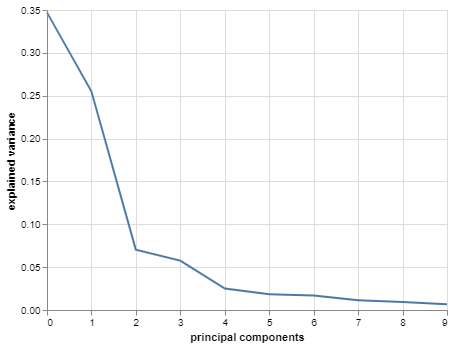

In [32]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

In [33]:
merged_pca_df = principalDf.merge(node_df, on="strain")

In [34]:
merged_pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,strain,date,y,region,country,parent_date,parent_y,clade_membership,clade_membership_color
0,-1.942113,4.284939,0.320994,-0.308557,0.052156,0.326734,0.250314,-0.026283,-0.018202,0.340586,A/Alabama/30/2017,2017.921918,531,N,USA,2017.778529,530.500000,A2/re,A2/re
1,-1.943538,4.278740,0.239846,-0.243645,0.118608,-0.157241,-0.166301,-0.024387,0.107360,0.353971,A/Florida/84/2017,2017.809589,532,N,USA,2017.778529,530.500000,A2/re,A2/re
2,-1.942405,4.279251,0.240868,-0.244150,0.116307,-0.158357,-0.166687,-0.024847,0.103659,0.355317,A/NorthDakota/23/2017,2017.858904,530,N,USA,2017.778529,530.500000,A2/re,A2/re
3,-2.216793,4.221554,0.315443,-0.255731,0.111530,-0.071657,-0.131070,0.022087,-0.011414,0.379678,A/Florida/18/2018,2018.083562,548,N,USA,2017.857268,547.000000,A2/re,A2/re
4,-2.210463,4.220489,0.363987,-0.177015,0.076668,0.062666,0.008472,0.016320,0.044112,0.354379,A/Indiana/31/2017,2017.908219,562,N,USA,2017.625276,538.366642,A2/re,A2/re


In [35]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

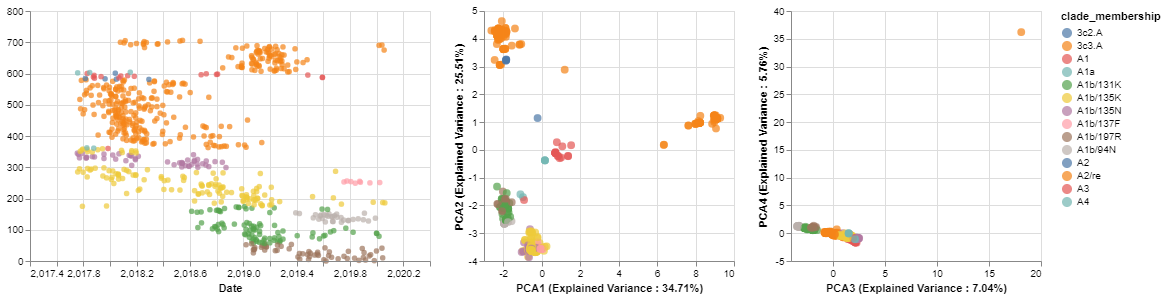

In [36]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain','region'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

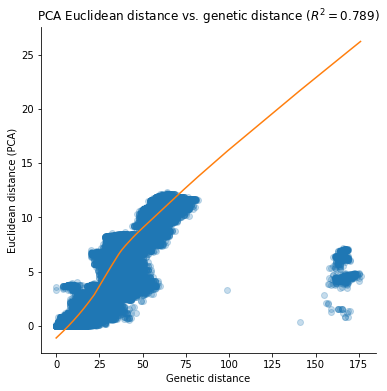

In [37]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_PCA = pd.read_csv("../seasonal-flu-nextstrain/results/scatterplot_pca.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_PCA["pearson_coef"].values.tolist()[0]))

sns.despine()

In [ ]:
PCA_KDE_df = pd.read_csv("../seasonal-flu-nextstrain/results/KDEDensity_pca.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the first 10 PCs - colored by region and clade

In [ ]:
reducer = umap.UMAP(n_neighbors=200,
        min_dist=.05,
        n_components=2,
        init="spectral")
X_transformed_umap_1 = reducer.fit_transform(genomes_df)
UMAP_PCA_df_1 = pd.DataFrame(X_transformed_umap_1,columns=['UMAP_' + str(i) for i in range(1,3)])
merged_umap_pca_df_1 = UMAP_PCA_df_1

In [ ]:
reducer = umap.UMAP(n_neighbors=200,
        min_dist=.05,
        n_components=2,
        init="spectral")
X_transformed_umap_pca = reducer.fit_transform(principalComponents)
UMAP_PCA_df = pd.DataFrame(X_transformed_umap_pca,columns=['UMAP' + str(i) for i in range(1,3)])
UMAP_PCA_df["strain"] = strains
merged_umap_pca_df = UMAP_PCA_df.merge(node_df, on="strain")

In [ ]:
new_df = merged_umap_pca_df.join(merged_umap_pca_df_1)

# By clade:

In [ ]:
list_of_data_and_titles = ['UMAP1','UMAP2', 'UMAP_1', 'UMAP_2']
list_of_chart = linking_tree_with_plots_brush(
   new_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership_color',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1].properties(title = "UMAP on genomic data")|list_of_chart[2].properties(title= "UMAP run on 10 PCs")
chart.save("docs/UmapPCLinkedClade" + virus_name + ".html")
chart.save("docs/UmapPCLinkedClade" + virus_name + ".svg", scale_factor=2.0)
drawing = svg2rlg("docs/UmapPCLinkedClade" + virus_name + ".svg")
renderPDF.drawToFile(drawing, "docs/UmapPCLinkedClade" + virus_name + ".pdf")

In [ ]:
UMAP_PCA_violin_df = get_euclidean_data_frame(merged_umap_pca_df, "UMAP1", "UMAP2", "UMAP")
g = sns.FacetGrid(
    UMAP_PCA_violin_df,
    col="embedding",
    col_wrap=3,
    sharey=False,
    height=4
)
g = g.map(sns.violinplot, "clade_status", "distance", order=["within", "between"])
g.set_axis_labels("Clade status", "Distance")
plt.savefig("docs/UMAPPCCladeViolinPlot" + virus_name + ".png")

# Running MDS on the Dataset

In [39]:
#principalDf = pd.read_csv(snakemake.input.pca)
MDS_df = pd.read_csv("../seasonal-flu-nextstrain/results/embed_mds.csv",index_col=0)

MDS_df["strain"] = MDS_df.index

In [40]:
merged_mds_df = MDS_df.merge(node_df, on="strain")

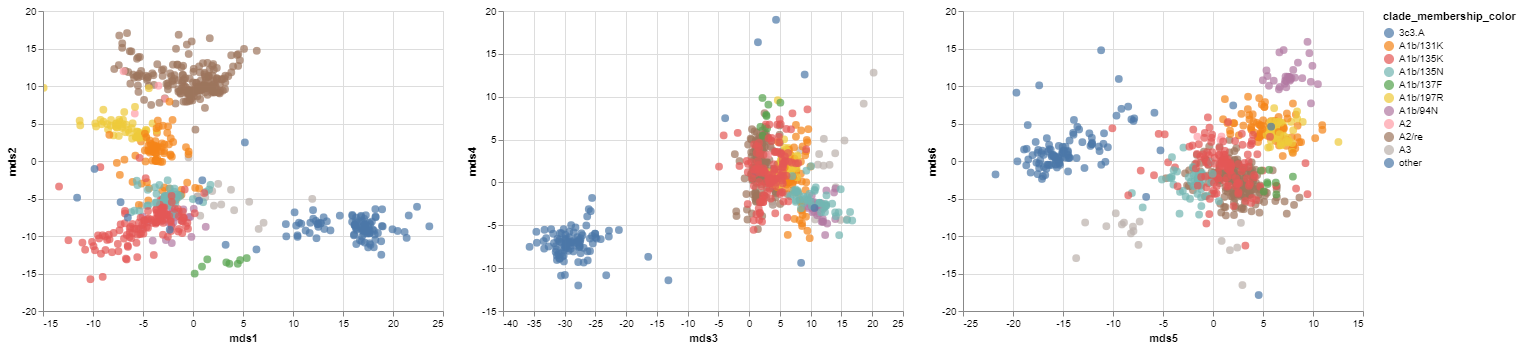

In [41]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

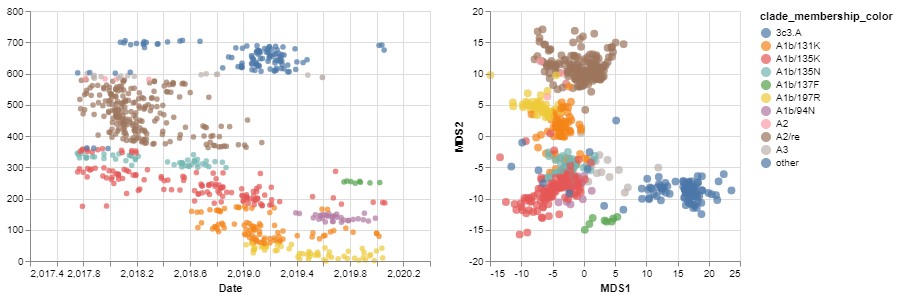

In [42]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership_color:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

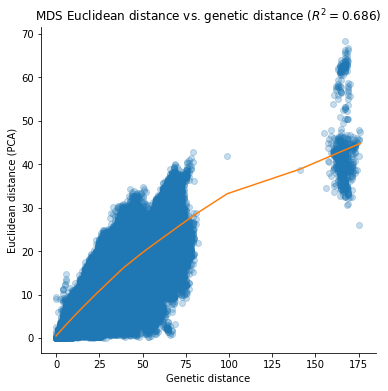

In [43]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_MDS = pd.read_csv("../seasonal-flu-nextstrain/results/scatterplot_mds.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_MDS["pearson_coef"].values.tolist()[0]))

sns.despine()

In [ ]:
MDS_KDE_df = pd.read_csv("../seasonal-flu-nextstrain/results/KDEDensity_mds.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [57]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = pd.read_csv("../seasonal-flu-nextstrain/results/embed_tsne.csv",index_col=0)

TSNE_df["strain"] = TSNE_df.index

In [58]:
TSNE_df

,tsne_x,tsne_y,strain
U26830.1,7.526290,8.661090,U26830.1
A/Alabama/30/2017,22.353794,6.618707,A/Alabama/30/2017
A/Florida/84/2017,22.354322,6.613440,A/Florida/84/2017
A/NorthDakota/23/2017,22.353256,6.614264,A/NorthDakota/23/2017
A/Florida/18/2018,21.175915,12.093012,A/Florida/18/2018
...,...,...,...
A/Ohio/08/2019,-21.405193,-31.424450,A/Ohio/08/2019
A/Florida/78/2019,-19.544842,-32.414776,A/Florida/78/2019
A/California/16/2020,-29.289719,-33.801003,A/California/16/2020
A/Minnesota/40/2018,-26.217716,-40.742016,A/Minnesota/40/2018


In [59]:
merged_tsne_df = TSNE_df.merge(node_df, on="strain")

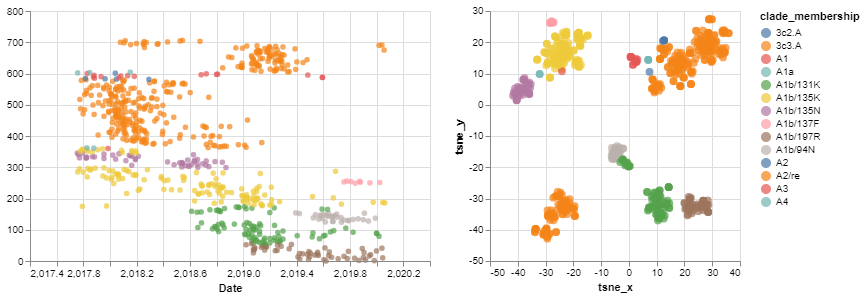

In [61]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

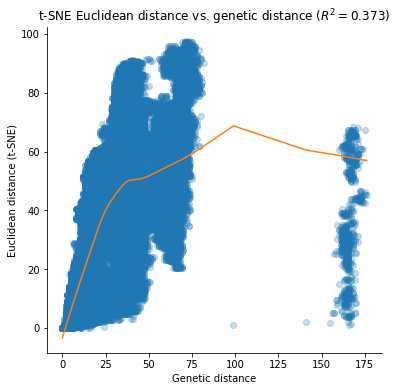

In [50]:
total_df_TSNE = pd.read_csv("../seasonal-flu-nextstrain/results/scatterplot_tsne.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_TSNE["pearson_coef"].values.tolist()[0]))

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

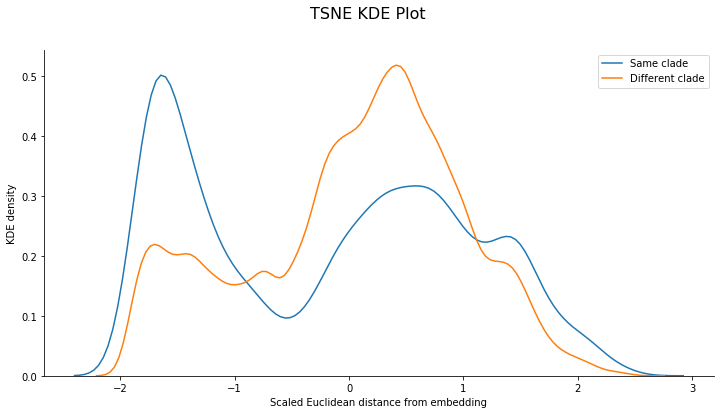

In [67]:
TSNE_KDE_df = pd.read_csv("../seasonal-flu-nextstrain/results/KDEDensity_mds.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [51]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("../seasonal-flu-nextstrain/results/embed_umap.csv",index_col=0)

UMAP_df["strain"] = UMAP_df.index

In [52]:
merged_umap_df = UMAP_df.merge(node_df, on="strain")

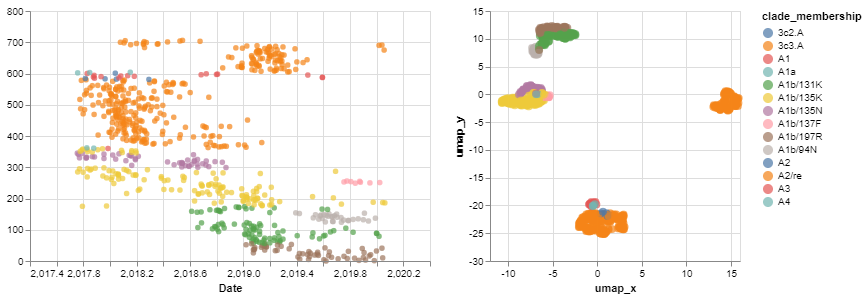

In [54]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

In [ ]:
UMAP_violin_df = get_euclidean_data_frame(merged_umap_df, "umap_x", "umap_y", "UMAP")

scaler = StandardScaler()

UMAP_violin_df["scaled_distance"] = scaler.fit_transform(pdist(UMAP_df.drop(["strain"], axis = 1)).reshape(-1, 1))

UMAP_violin_df["genetic_distance"] = squareform(similarity_matrix).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

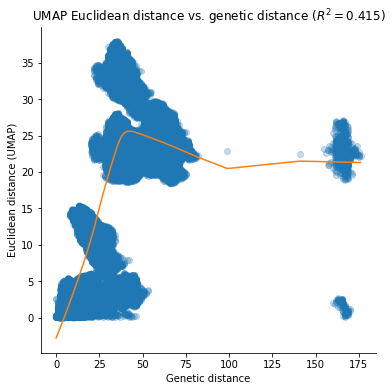

In [55]:
total_df_UMAP = pd.read_csv("../seasonal-flu-nextstrain/results/scatterplot_umap.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_UMAP["pearson_coef"].values.tolist()[0]))

sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

In [ ]:
UMAP_KDE_df = pd.read_csv("../seasonal-flu-nextstrain/results/KDEDensity_umap.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [ ]:
merged_df = node_df.merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [ ]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['MDS1', 'MDS2','TSNE1', 'TSNE2', 'PCA1', 'PCA2', 'UMAP1', 'UMAP2'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership_color:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [ ]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".html")
fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

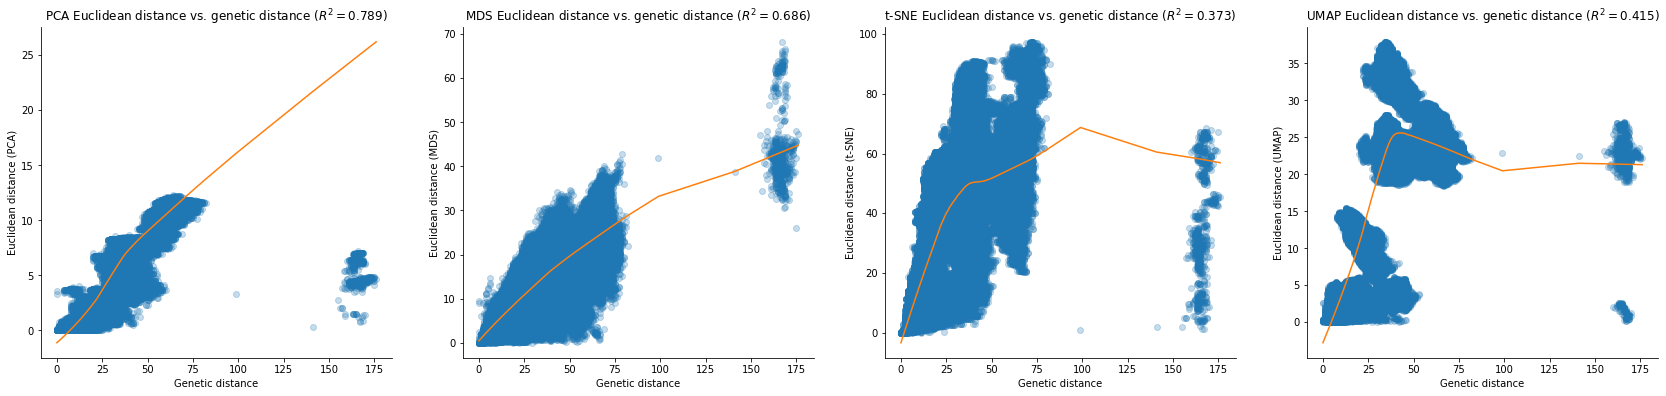

In [56]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_PCA["pearson_coef"].values.tolist()[0]))

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_MDS["pearson_coef"].values.tolist()[0]))

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_TSNE["pearson_coef"].values.tolist()[0]))

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_UMAP["pearson_coef"].values.tolist()[0]))


sns.despine()
#plt.savefig("docs/FullScatterplot" + virus_name + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [ ]:
# ADD GENETIC PLOT HERE 
fig, axes = plt.subplots(1, 4, figsize=(28, 6))

ax = axes[0]
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'within'")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'between'")["genetic_distance"], label="Different clade", ax=ax)
ax.set_title('PCA')
ax.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax.set_ylabel("KDE density")

#MDS
ax = axes[1]
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('MDS')
ax.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax.set_ylabel("KDE density")

#TSNE
ax = axes[2]
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('TSNE')
ax.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax.set_ylabel("KDE density")

#UMAP
ax = axes[3]
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_violin_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('UMAP')
ax.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()